## Logarithmic transformation

In [ ]:
#@title Load Data
# Provide Credentials

from google.colab import auth
auth.authenticate_user()
print('Authenticated')


#@title - abilities_hourly
from datetime import datetime
from google.cloud import bigquery
client = bigquery.Client( 'shopline-142003')

print( 'Start : ', datetime.now())

df_gmv = client.query('''

WITH orders_gmv AS (
SELECT
    o.*,
    total_cents_in_usd * c.exchange_rate AS total_cents_exchanged,
    subtotal_cents_in_usd * c.exchange_rate AS subtotal_cents_exchanged
FROM (
  SELECT 
    seller_id,
    total_cents_in_usd,
    subtotal_cents_in_usd,
    created_at
  FROM 
    `shopline-test.looker_prod.orders_hourly` as orders_hourly
  WHERE
      orders_hourly.last_fulfilled_at IS NOT NULL AND
      orders_hourly.status <> 'removed' AND
      orders_hourly.customer_type = 'User'
    ) o,
    (SELECT exchange_rate FROM `shopline-test.looker_prod.currency` WHERE iso_code = 'USD' ) c
WHERE
  total_cents_in_usd * (SELECT exchange_rate FROM `shopline-test.looker_prod.currency` WHERE iso_code = 'HKD') < 50000 OR
  -- Whitelist B2B merchants
  seller_id IN ('599455136ef2d44cd7000ab6', '5b6fb9f833e33c0017ffc639', '5be538edc0d24a0001abfcff', '586cada059d52493f3000cb3', '5cc813ba527c4b0001a31e32')
)
, merchants_hourly AS (
SELECT 
  _id, 
  handle, 
  current_plan_key,
  CASE
    -- "pos_trial" plan key has been updated while executing BigQuery scheduled queries
    WHEN REGEXP_CONTAINS( current_plan_key, r"free|_trial") THEN "Trial"
    WHEN REGEXP_CONTAINS( current_plan_key, r"o2o") THEN "O2O"
    WHEN REGEXP_CONTAINS( current_plan_key, r"enterprise_year") THEN "Enterprise"
    WHEN REGEXP_CONTAINS( current_plan_key, r"crossborder_year") THEN "Cross Border"
    WHEN REGEXP_CONTAINS( current_plan_key, r"premium_") THEN "Premium"
    WHEN REGEXP_CONTAINS( current_plan_key, r"business_*|advanced_*") THEN "Advanced"
    WHEN REGEXP_CONTAINS( current_plan_key, r"pos_") THEN "POS"
    WHEN current_plan_key = "locked" THEN "Locked"
    ELSE "Basic"
    END
    AS reclass_plan_key
FROM 
  `shopline-test.looker_prod.merchants_hourly`
)
, merchants_gmv AS (
SELECT 
    seller_id,
    reclass_plan_key,
    handle,
    SUM(total_cents_exchanged) AS sum_total_revenue
FROM 
  orders_gmv
  JOIN merchants_hourly ON merchants_hourly._id = orders_gmv.seller_id
WHERE 
  DATE(created_at) >=
  DATE(TIMESTAMP_ADD(TIMESTAMP_TRUNC(TIMESTAMP(FORMAT_TIMESTAMP('%F %H:%M:%E*S', CURRENT_TIMESTAMP(), 'Asia/Hong_Kong')), DAY), INTERVAL -90 DAY))
GROUP BY 
  seller_id,
  reclass_plan_key,
  handle
)
, abilities_hourly AS (
  SELECT
    * EXCEPT(row_number, status)
  FROM (
    SELECT 
      owner_id, 
      resource_owner_id,
      status,
      ROW_NUMBER() OVER (PARTITION BY owner_id,resource_owner_id ORDER BY updated_at DESC) row_number
    FROM
      `shopline-142003.datawarehouse.abilities_hourly` 
    WHERE 
      -- admin page permission : scope IS NULL
      scope IS NULL)
  WHERE 
    row_number= 1
    AND status != 'removed' -- the user account is not removed from admin staff page
)
, users_hourly AS (
  SELECT
    *
  FROM (
        SELECT
          users_hourly._id,
          users_hourly.updated_at,
          email,
          max(users_hourly.is_staff_of_merchant_ids) over (partition by users_hourly._id order by users_hourly.updated_at DESC) AS is_staff_of_merchant_ids,
          ROW_NUMBER() OVER (PARTITION BY _id ORDER BY updated_at DESC) row_number
        FROM
          `shopline-142003.datawarehouse.users_hourly` AS users_hourly
        WHERE 
          users_hourly.owner_id = '536148ab1311667d72000001' -- admin
          AND users_hourly._id NOT IN ('51d42a3165be0c950f000001','529ee727131166795d00005a','545a5d92039055f71d000013', '51d4baea65be0cc119000005','534a9f901311665112000024')
      ) AS users_hourly
      JOIN abilities_hourly 
        ON abilities_hourly.owner_id = users_hourly._id
        AND LENGTH(users_hourly.is_staff_of_merchant_ids) > LENGTH( Replace(users_hourly.is_staff_of_merchant_ids, resource_owner_id, ''))
  WHERE 
    row_number =1 
    AND LENGTH(is_staff_of_merchant_ids) > 0
--     AND NOT REGEXP_CONTAINS(email, r"@shopline\w*.com|@shopline\w*.cpm") 
)
-- , base AS (
SELECT
  merchants_gmv.seller_id AS merchant_id,
  handle,
  reclass_plan_key,
  sum_total_revenue,
  ROUND(ROW_NUMBER() OVER (ORDER BY sum_total_revenue DESC) / COUNT (DISTINCT merchants_gmv.seller_id ) OVER() *100, 2) AS gmv_rank,
  COUNT( DISTINCT users_hourly.owner_id) nAssignedStaffs
FROM 
  merchants_gmv  
  LEFT JOIN users_hourly  
    ON merchants_gmv.seller_id = users_hourly.resource_owner_id 
GROUP BY
  merchants_gmv.seller_id,
  handle,
  reclass_plan_key,
  sum_total_revenue
ORDER BY
  nAssignedStaffs ASC


''' ).to_dataframe()

print( 'Done : ', datetime.now())
print(df_gmv.shape)
df_gmv.sample(5)

Authenticated
Start :  2020-07-03 06:27:58.316890
Done :  2020-07-03 06:28:07.449523
(9486, 6)


,merchant_id,handle,reclass_plan_key,sum_total_revenue,gmv_rank,nAssignedStaffs
1183,5e8545d8fc330800226a2309,sevendeadlysin,Locked,5264.098902,38.71,0
4939,5bfd43e202dd95000178fdb9,valeriefood,Advanced,13936.961538,25.85,1
4721,56864096e36c8e65e9000006,yourmakeupstoreph,Advanced,42958.419383,13.56,1
9288,5d6369c1f982a4000166f600,inooknit,Enterprise,8865.033333,31.65,12
5477,5e8ef8cbfc3308000a6a2449,cs746,Premium,1449.743590,56.15,1


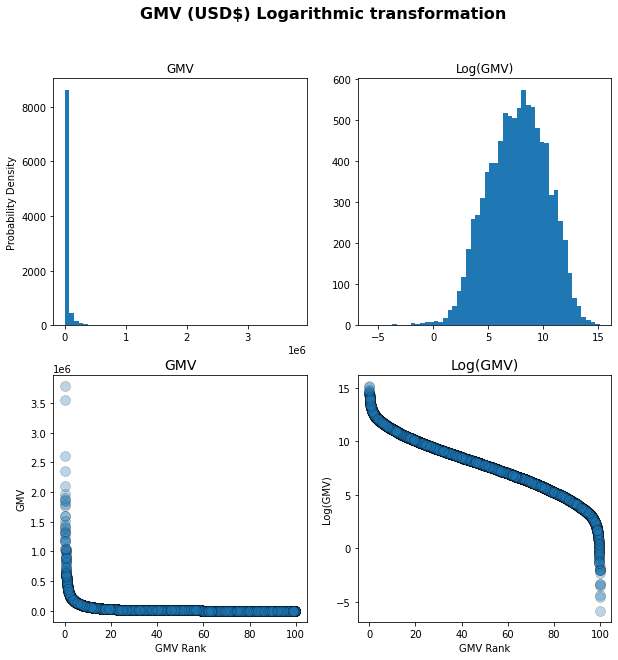

In [ ]:
#@title Visualization
import numpy as np
import matplotlib.pyplot as plt

n_bins = 50

df = df_gmv.copy()
s = df[df.sum_total_revenue > 0].sum_total_revenue
log_s = np.log(s)   ## 取log

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax0, ax1, ax2, ax3 = axes.flatten()

######### Probability #########
ax0.hist(s, n_bins, histtype='bar')
ax0.set_title('GMV')
ax0.set_ylabel('Probability Density')

ax1.hist(log_s, n_bins, histtype='bar')
ax1.set_title('Log(GMV)')

######### Rank #########
df = df_gmv.copy()
df = df[df.sum_total_revenue > 0]
df['log_gmv'] = np.log(df.sum_total_revenue)

x = df.gmv_rank
y = df.sum_total_revenue
log_y = df.log_gmv

ax2.plot(x,  y, 'o' ,  alpha=0.3, markersize=10, markeredgecolor = 'black', markeredgewidth = 0.5 )
ax2.set_title('GMV', fontsize=14)
ax2.set_ylabel('GMV')
ax2.set_xlabel('GMV Rank')

ax3.plot(x,  log_y, 'o' ,  alpha=0.3, markersize=10, markeredgecolor = 'black', markeredgewidth = 0.5 )
ax3.set_xlabel('GMV Rank')
ax3.set_ylabel('Log(GMV)')
ax3.set_title('Log(GMV)', fontsize=14)

fig.suptitle('GMV (USD$) Logarithmic transformation', fontsize=16, fontweight='bold')

plt.show()


# Standardization

# Normalization

# Decompose

### Moving Average

- https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/
- https://towardsdatascience.com/implementing-moving-averages-in-python-1ad28e636f9d
- https://towardsdatascience.com/implementing-macd-in-python-cc9b2280126a


### Decomposition
- https://stackoverflow.com/questions/38011931/python-statsmodels-time-series-decomposition-duplicate-plot
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
- https://rpubs.com/SophiaGao/58821
- https://medium.com/pinterest-engineering/building-a-real-time-anomaly-detection-system-for-time-series-at-pinterest-a833e6856ddd
- https://towardsdatascience.com/anomaly-detection-def662294a4e


In [11]:
#@title Load Data

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from datetime import datetime
from google.cloud import bigquery

client = bigquery.Client( 'shopline-142003')

print( 'Query Start : ', datetime.now())

row_data = client.query('''

WITH orders_gmv AS (
SELECT
    o.*,
    total_cents_in_usd * c.exchange_rate AS total_cents_exchanged
FROM (
  SELECT 
    seller_id,
    total_cents_in_usd,
    subtotal_cents_in_usd,
    created_at
  FROM 
    `shopline-test.looker_prod.orders_hourly` as orders_hourly
  WHERE
      orders_hourly.last_fulfilled_at IS NOT NULL AND
      orders_hourly.status <> 'removed' AND
      orders_hourly.customer_type = 'User'
    ) o,
    (SELECT exchange_rate FROM `shopline-test.looker_prod.currency` WHERE iso_code = 'USD' ) c
WHERE
  total_cents_in_usd * (SELECT exchange_rate FROM `shopline-test.looker_prod.currency` WHERE iso_code = 'HKD') < 50000 
  AND seller_id IN (SELECT _id FROM `shopline-test.looker_prod.merchants_hourly` WHERE handle in ('erwachen', 'bonnyread', 'info214', 'aroom1988','sddmarket813'))
)
, merchants_hourly AS (
SELECT 
  _id, 
  handle, 
FROM 
  `shopline-test.looker_prod.merchants_hourly`
WHERE   
  handle in ('erwachen', 'bonnyread', 'info214', 'aroom1988', 'sddmarket813')
)
-- , merchants_gmv AS (
SELECT 
    seller_id,
    handle,
    DATE(created_at, 'Asia/Taipei') AS xDate,
    SUM( total_cents_exchanged ) AS sum_total_revenue,
    SUM( total_cents_exchanged ) / MAX( SUM( total_cents_exchanged ) ) OVER (PARTITION BY handle) AS gmv_normalized
FROM 
  orders_gmv
  JOIN merchants_hourly ON merchants_hourly._id = orders_gmv.seller_id
WHERE 
  DATE(created_at, 'Asia/Taipei') >=
  DATE(TIMESTAMP_ADD(TIMESTAMP_TRUNC(TIMESTAMP(FORMAT_TIMESTAMP('%F %H:%M:%E*S', CURRENT_TIMESTAMP(), 'Asia/Hong_Kong')), DAY), INTERVAL -90 DAY))
  AND DATE(created_at, 'Asia/Taipei') < DATE(TIMESTAMP_TRUNC(TIMESTAMP(FORMAT_TIMESTAMP('%F %H:%M:%E*S', CURRENT_TIMESTAMP(), 'Asia/Hong_Kong')), DAY))
GROUP BY 
  seller_id,
  handle,
  xDate
ORDER BY 
  handle,
  xDate
  

''' ).to_dataframe()

print( 'Query Done : ', datetime.now())
print(row_data.shape)
row_data.sample(5)

Authenticated
Query Start :  2020-07-08 02:08:52.127711
Query Done :  2020-07-08 02:08:56.247024
(450, 5)


,seller_id,handle,xDate,sum_total_revenue,gmv_normalized
305,5ceb666ffea1260001377cdb,info214,2020-05-14,6052.233333,0.046723
293,5ceb666ffea1260001377cdb,info214,2020-05-02,34688.133333,0.267790
189,5ab1cd1b72fdc0d20c0011b2,erwachen,2020-04-18,14205.066667,0.055732
408,5b290f6410abb9fc88000e9a,sddmarket813,2020-05-27,5172.466667,0.567273
318,5ceb666ffea1260001377cdb,info214,2020-05-27,7734.166667,0.059707


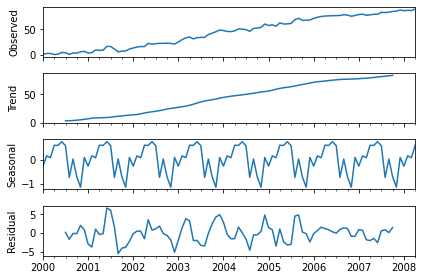

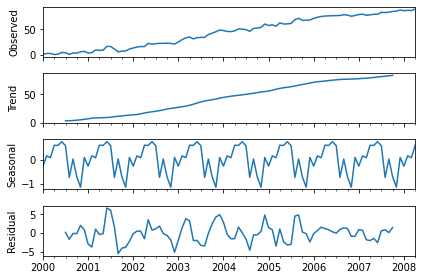

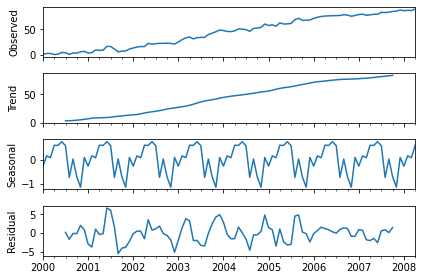

In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from matplotlib import pylab as plt

# fig, ax = plt.subplots()

#defining the trend function
def trend(t, amp=1):
    return amp*(1 + t)

n_time_steps = 100
amplitud=1
#initializing the time series
time_series = np.zeros(n_time_steps)
time_series[0] = trend(0, amplitud)

alpha = 0.1
#making the time series
for t in range(1,n_time_steps):
    time_series[t] = (1 - alpha)*time_series[t - 1] + alpha*trend(t, amp=amplitud) + alpha*np.random.normal(0,25)

#passing the time series to a pandas format
dates = sm.tsa.datetools.dates_from_range('2000m1', length=len(time_series))
time_series_pd= pd.Series(time_series, index=dates)

#decomposing the time series
res = sm.tsa.seasonal_decompose(time_series_pd)
res.plot()

